In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy.stats import norm, uniform

import fig_settings as fs
from src import *

In [2]:
colors = ["#5f6366", "#3768d2", "#005b7a", "#a6cebd"]
fs.set_fonts()
idx1 = 0
idx2 = 1
idx3 = 2

In [19]:
n = 100
alpha = 1e-7

training_time = 300  # training time/
testing_time = 10
frac = 0.5
dt = 0.01

w_in_sigma = 0.001

gateR = 2.7e4
gateC = 8.98e-7
pinchoff = -0.6

parameters = dict()
parameters["transconductance"] = {"mean": 0.582e-3, "stddev": 0.0582e-3}
parameters["channel-width"] = {"mean": 200e-6, "stddev": 0}
parameters["channel-length"] = {"mean": 101e-6, "stddev": 0}
parameters["pinchoff-voltage"] = {"mean": pinchoff, "stddev": 0}  # pinch-off voltage
parameters["weighting-resistor"] = {"mean": 500, "stddev": 100}
parameters["gate-capacitance"] = {"mean": gateC, "stddev": 0.1 * gateC}
parameters["gate-resistance"] = {"mean": gateR, "stddev": 0.1 * gateR}
parameters["applied-drain-voltage"] = {"mean": -0.05, "stddev": 0}

# system
D = 3
r_dist = uniform(100, 500)
delta_dist = norm(scale=0.1)
p = 6 / n
# plist = np.logspace(-3, 0, 16)
# p = plist[3]
sigma = 10
rho = 28
beta = 8 / 3

In [20]:
u0list = generate_initial_conditions(
    10,
    [-7.4, -11.1, 20],
    delta_dist,
    10,
    1e-4,
    lorenz,
    sigma=10,
    rho=28,
    beta=8 / 3,
)

u0 = u0list[0]

In [11]:
# OECT parameters
Vdinit, R, Rg, Cg, Vp, Kp, W, L = generate_OECT_parameters(n, parameters)

A = erdos_renyi_network(n, p, r_dist)

w_in = input_layer(D, n, w_in_sigma)

In [12]:
nx.is_connected(nx.Graph(A))

True

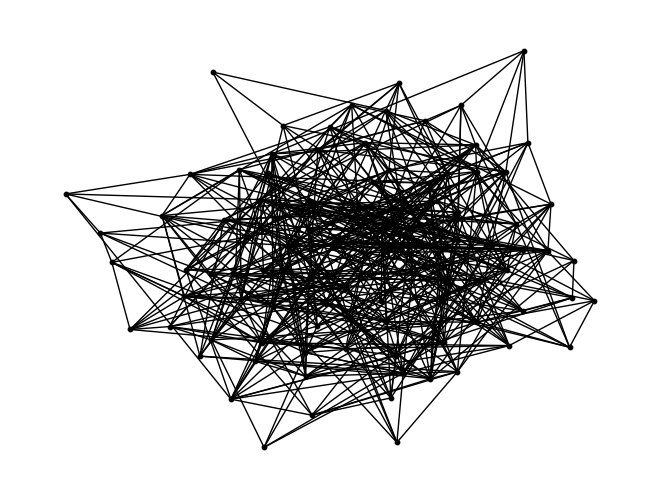

In [13]:
nx.draw(nx.Graph(A), node_size=10, node_color="black")

In [14]:
w_out, uf, r0, V1_0 = train_oect_reservoir(
    u0.copy(),
    training_time,
    dt,
    frac,
    w_in,
    A,
    alpha,
    Vdinit,
    R,
    Rg,
    Cg,
    Vp,
    Kp,
    W,
    L,
    lorenz,
    sigma=sigma,
    rho=rho,
    beta=beta,
)

In [15]:
t, signal_oect, prediction_oect = run_oect_reservoir_autonomously(
    uf,
    r0,
    V1_0,
    testing_time,
    dt,
    w_in,
    w_out,
    A,
    Vdinit,
    R,
    Rg,
    Cg,
    Vp,
    Kp,
    W,
    L,
    lorenz,
    sigma=sigma,
    rho=rho,
    beta=beta,
)

In [16]:
w_out, uf, r = train_reservoir(
    u0.copy(),
    A,
    training_time,
    dt,
    frac,
    w_in,
    alpha,
    lorenz,
    0,
    sigma=sigma,
    rho=rho,
    beta=beta,
)

In [17]:
## Run reservoir autonomously.
t, signal_tanh, prediction_tanh = run_reservoir_autonomously(
    uf,
    r,
    A,
    testing_time,
    dt,
    w_in,
    w_out,
    lorenz,
    0,
    sigma=sigma,
    rho=rho,
    beta=beta,
)

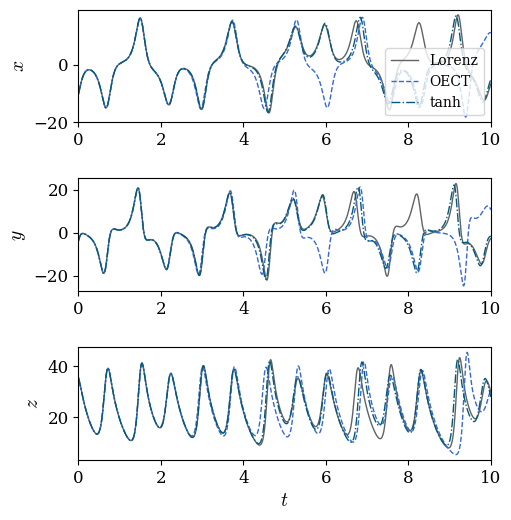

In [18]:
linewidth = 1
tmax = 10

plt.figure(figsize=(5.5, 6))

# change space between plots
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.ylabel(r"$x$")
plt.plot(
    t, signal_tanh[:, 0], "-", color=colors[idx1], linewidth=linewidth, label="Lorenz"
)
plt.plot(
    t,
    prediction_oect[:, 0],
    "--",
    color=colors[idx2],
    linewidth=linewidth,
    label="OECT",
)
plt.plot(
    t,
    prediction_tanh[:, 0],
    "-.",
    color=colors[idx3],
    linewidth=linewidth,
    label="tanh",
)
plt.xlim([0, tmax])
plt.legend(loc="lower right")

plt.subplot(312)
plt.ylabel(r"$y$")
plt.plot(t, signal_tanh[:, 1], "-", color=colors[idx1], linewidth=linewidth)
plt.plot(t, prediction_oect[:, 1], "--", color=colors[idx2], linewidth=linewidth)
plt.plot(t, prediction_tanh[:, 1], "-.", color=colors[idx3], linewidth=linewidth)
plt.xlim([0, tmax])

plt.subplot(313)
plt.ylabel(r"$z$")
plt.plot(t, signal_tanh[:, 2], "-", color=colors[idx1], linewidth=linewidth)
plt.plot(t, prediction_oect[:, 2], "--", color=colors[idx2], linewidth=linewidth)
plt.plot(t, prediction_tanh[:, 2], "-.", color=colors[idx3], linewidth=linewidth)
plt.xlim([0, tmax])

plt.xlabel(r"$t$")

plt.subplots_adjust(left=0.15, right=0.9, top=0.9, bottom=0.15)

plt.show()